#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16530, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 16530 (delta 1), reused 5 (delta 0), pack-reused 16522
Receiving objects: 100% (16530/16530), 15.05 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (11354/11354), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00
Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


# Download a Dataset


In [3]:
!pip install -q roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="DNTf16HeFhkUJQ2C6EnM")
project = rf.workspace("sharks-hsbfu").project("sharkspotting-uqso9")
version = project.version(3)
dataset = version.download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SharkSpotting-3 in yolov5pytorch:: 100%|██████████| 13890/13890 [00:01<00:00, 8362.89it/s]


In [4]:
%cd /content/yolov5

/content/yolov5


In [5]:
%cat {dataset.location}/data.yaml

names:
- boat
- other animal
- person
- shark
nc: 4
roboflow:
  license: MIT
  project: sharkspotting-uqso9
  url: https://universe.roboflow.com/project/sharkspotting-uqso9/dataset/3
  version: 3
  workspace: project
test: ../test/images
train: SharkSpotting-3/train/images
val: SharkSpotting-3/valid/images


# Define Model Configuration and Architecture

In [6]:
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [8]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [10]:
# train yolov5s on custom data for 200 epochs
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-10 01:40:54.679833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 01:40:54.679887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 01:40:54.681693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 01:40:55.780272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/SharkSpotting-3/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False,

# Evaluate Custom YOLOv5 Detector Performance

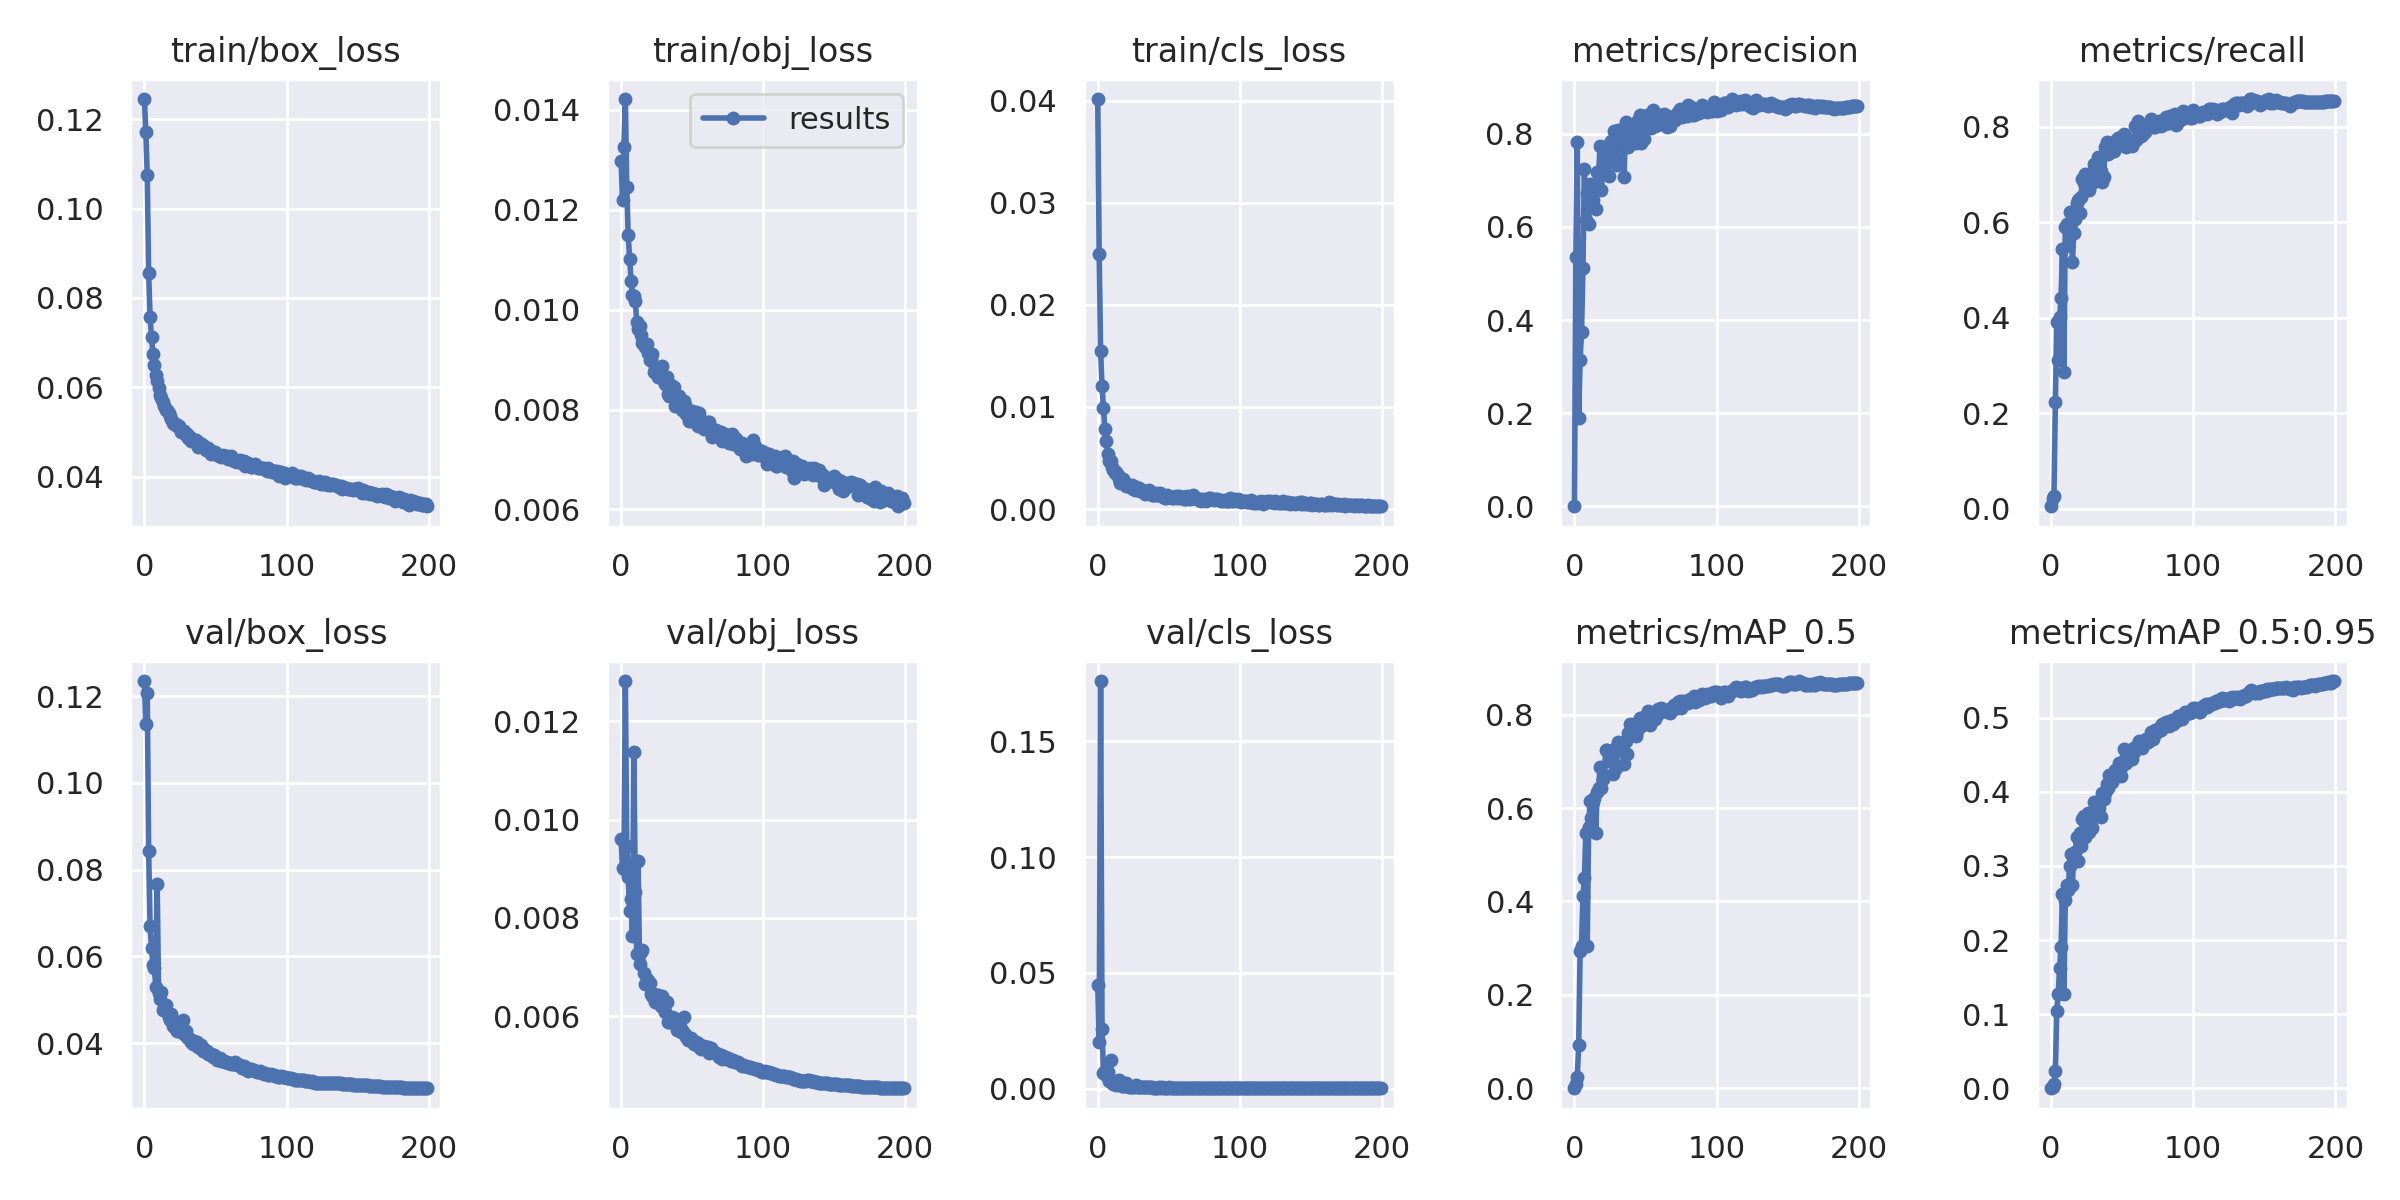

In [11]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

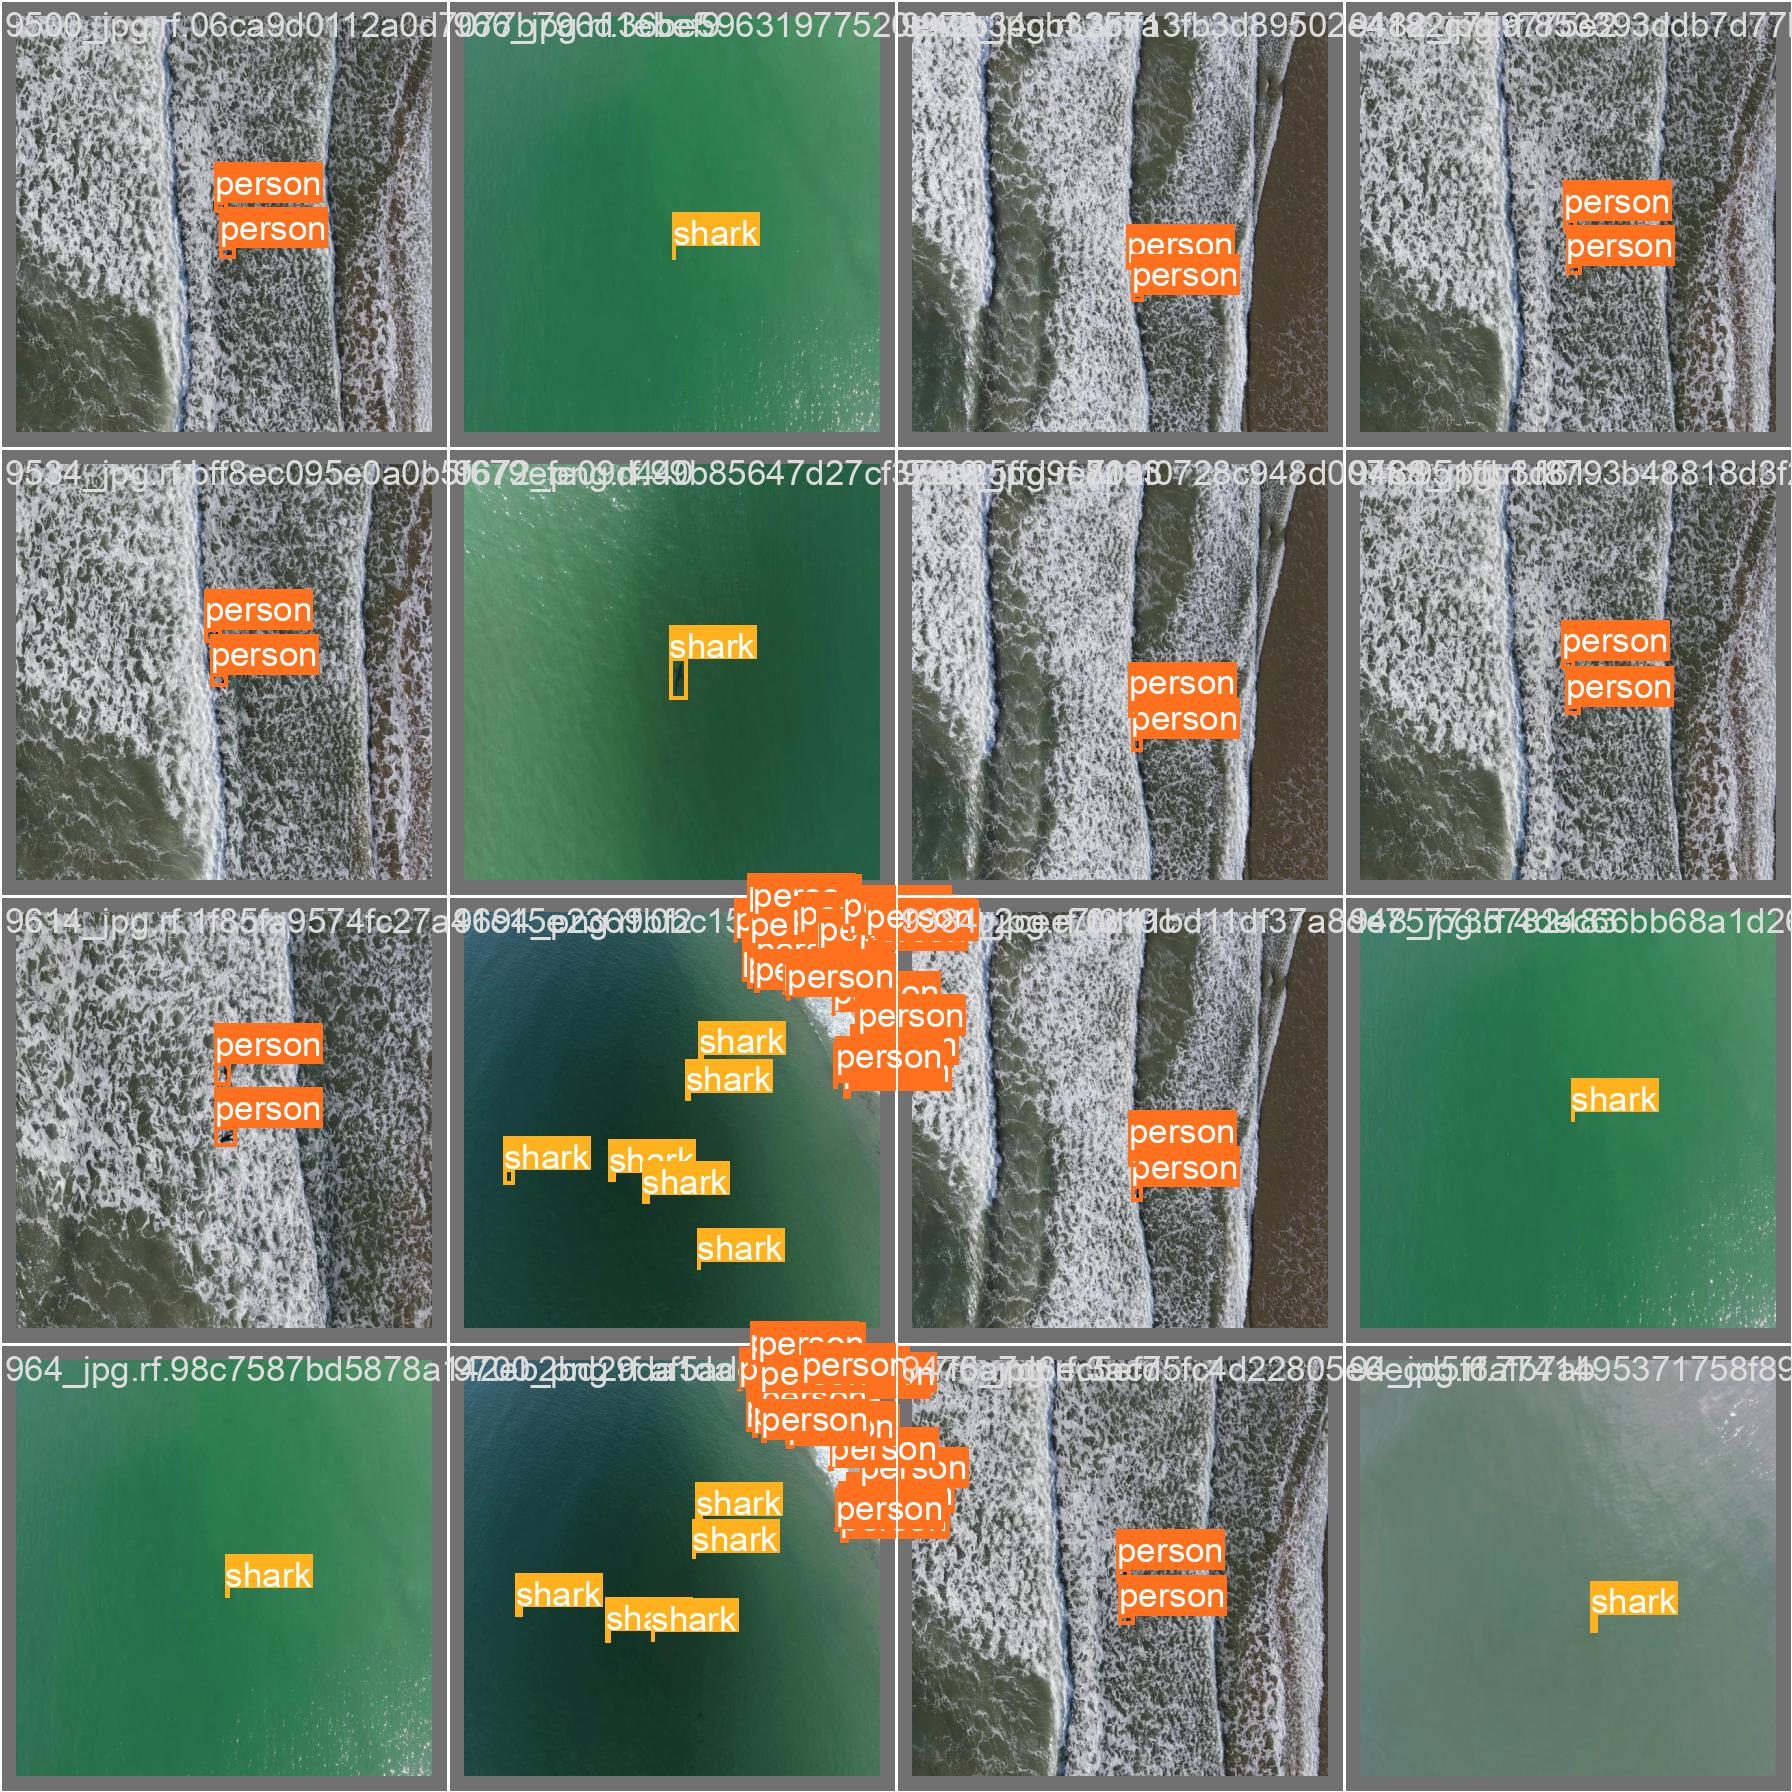

In [12]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


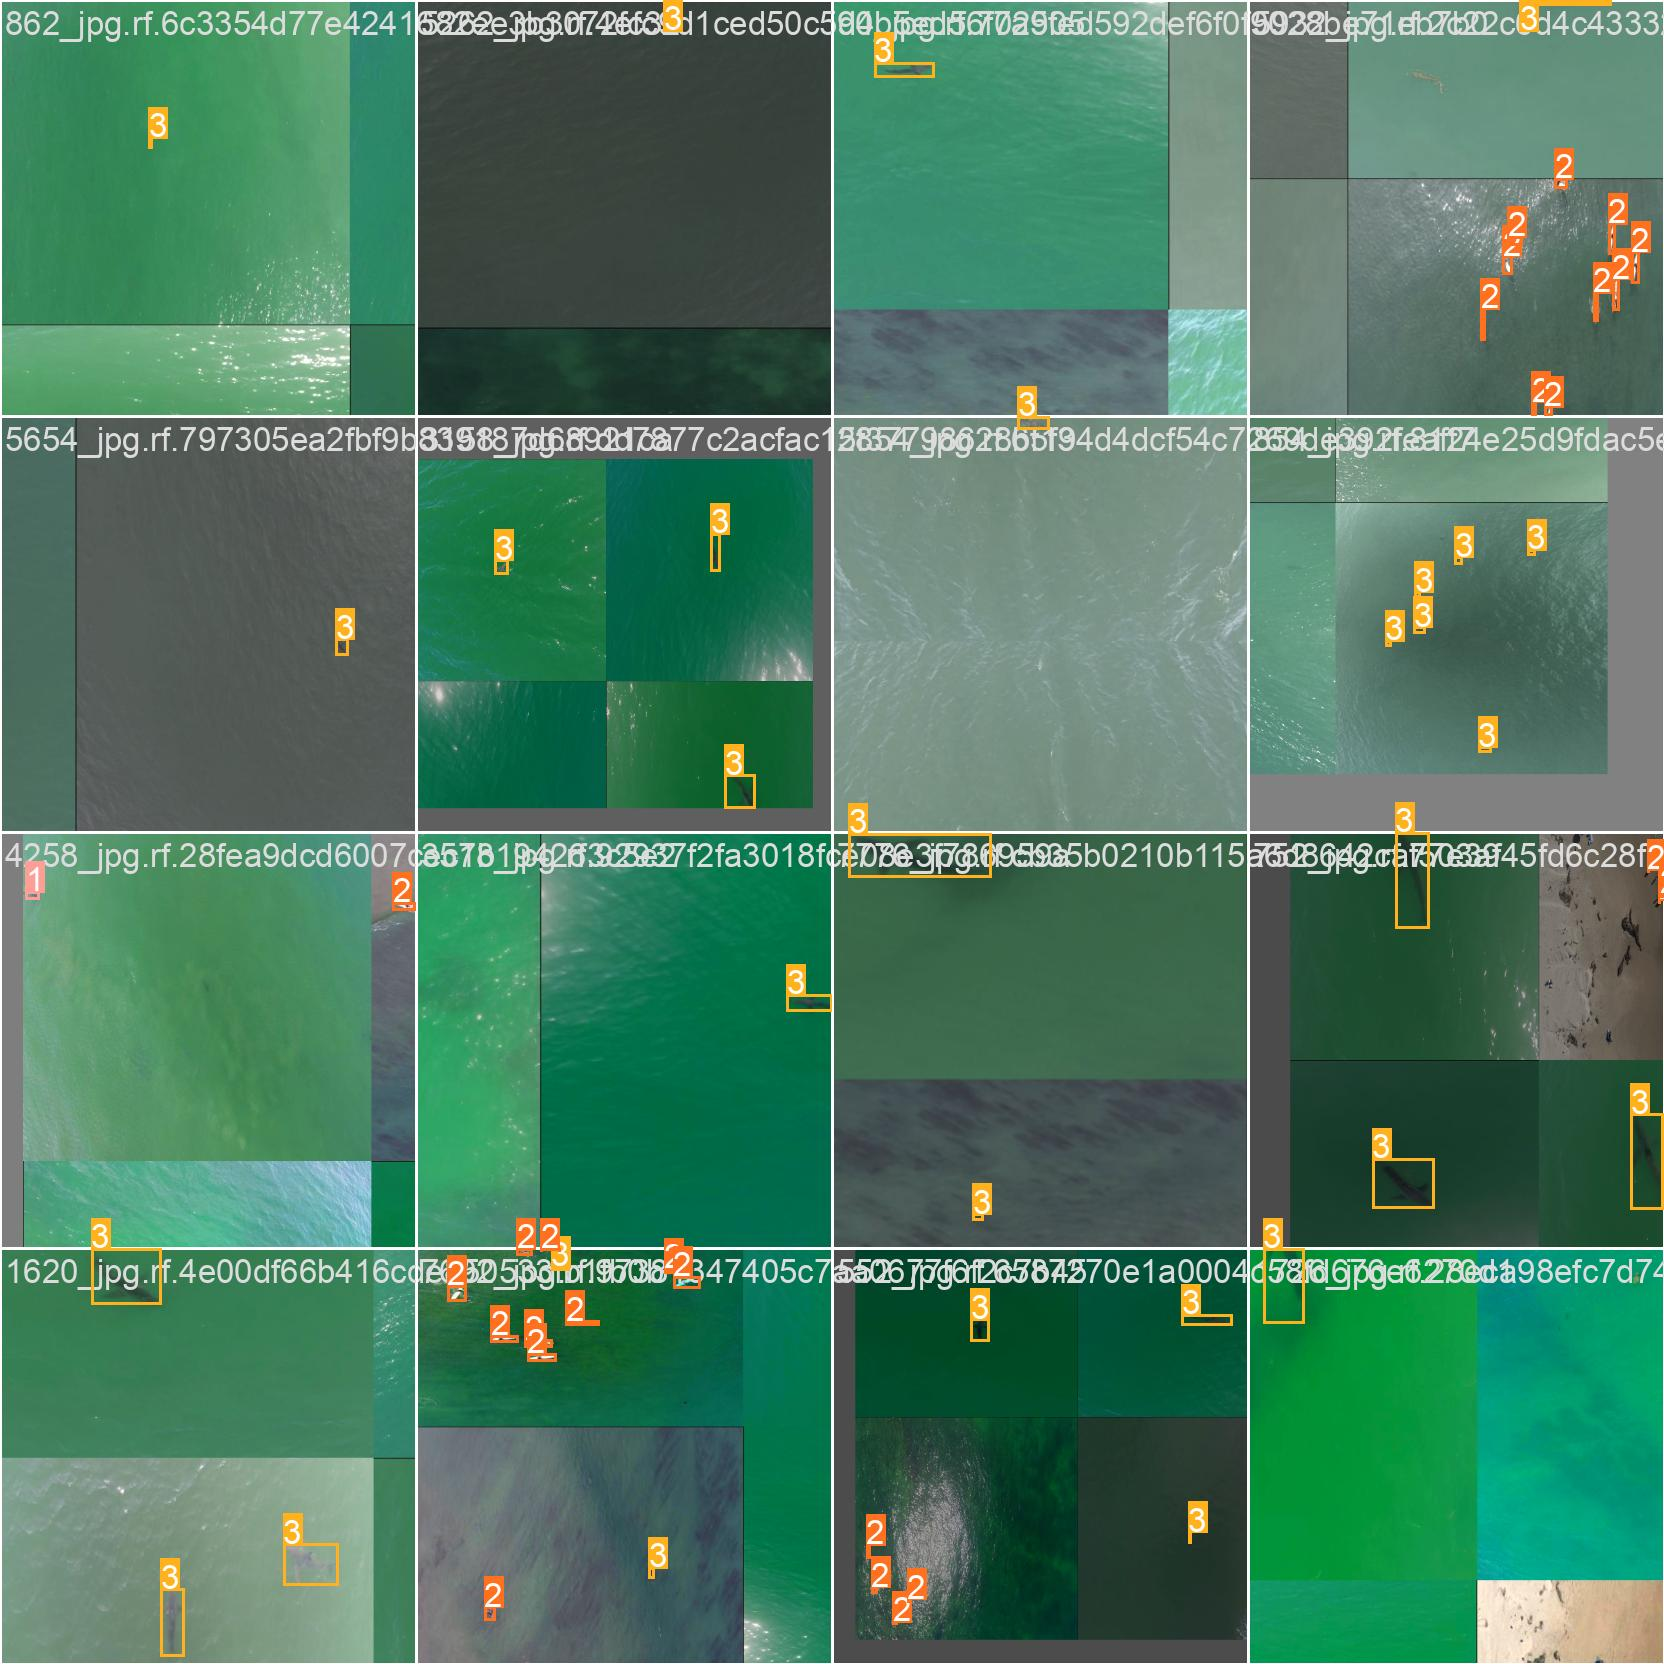

In [13]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

In [14]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [15]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [16]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source Cash-Counter-10/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=Cash-Counter-10/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return f

In [17]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive


In [ ]:
%cp -r /content/yolov5/runs/train/yolov5s_results/ /content/gdrive/My\ Drive